In [15]:
import os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import random
import numpy as np
import seaborn as sns


base_path = r"C:\Users\arfin\Downloads\covid xray\COVID-19_Radiography_Dataset\COVID-19_Radiography_Dataset"

# Load each metadata file
df_covid = pd.read_excel(os.path.join(base_path, "COVID.metadata.xlsx"))
df_normal = pd.read_excel(os.path.join(base_path, "Normal.metadata.xlsx"))
df_opacity = pd.read_excel(os.path.join(base_path, "Lung_Opacity.metadata.xlsx"))
df_pneumonia = pd.read_excel(os.path.join(base_path, "Viral Pneumonia.metadata.xlsx"))


In [ ]:
# Add labels
df_covid["label"] = "COVID"
df_normal["label"] = "Normal"
df_opacity["label"] = "Lung_Opacity"
df_pneumonia["label"] = "Viral Pneumonia"

# Combine
df_all = pd.concat([df_covid, df_normal, df_opacity, df_pneumonia], ignore_index=True)
print(df_all.head(10))

  FILE NAME FORMAT     SIZE  \
0   COVID-1    PNG  256*256   
1   COVID-2    PNG  256*256   
2   COVID-3    PNG  256*256   
3   COVID-4    PNG  256*256   
4   COVID-5    PNG  256*256   
5   COVID-6    PNG  256*256   
6   COVID-7    PNG  256*256   
7   COVID-8    PNG  256*256   
8   COVID-9    PNG  256*256   
9  COVID-10    PNG  256*256   

                                                 URL  label  
0  https://sirm.org/category/senza-categoria/covi...  COVID  
1  https://sirm.org/category/senza-categoria/covi...  COVID  
2  https://sirm.org/category/senza-categoria/covi...  COVID  
3  https://sirm.org/category/senza-categoria/covi...  COVID  
4  https://sirm.org/category/senza-categoria/covi...  COVID  
5  https://sirm.org/category/senza-categoria/covi...  COVID  
6  https://sirm.org/category/senza-categoria/covi...  COVID  
7  https://sirm.org/category/senza-categoria/covi...  COVID  
8  https://sirm.org/category/senza-categoria/covi...  COVID  
9  https://sirm.org/category/senza-cat

In [ ]:
#basic stats
print("Total images:", len(df_all))
print("\nLabel Distribution:\n", df_all['label'].value_counts())
print("\nUnique image sizes:\n", df_all['SIZE'].value_counts())
print("\nFile formats:\n", df_all['FORMAT'].value_counts())
print(df_all.columns.tolist())

Total images: 21165

Label Distribution:
 label
Normal             10192
Lung_Opacity        6012
COVID               3616
Viral Pneumonia     1345
Name: count, dtype: int64

Unique image sizes:
 SIZE
256*256    21165
Name: count, dtype: int64

File formats:
 FORMAT
PNG    21165
Name: count, dtype: int64
['FILE NAME', 'FORMAT', 'SIZE', 'URL', 'label']


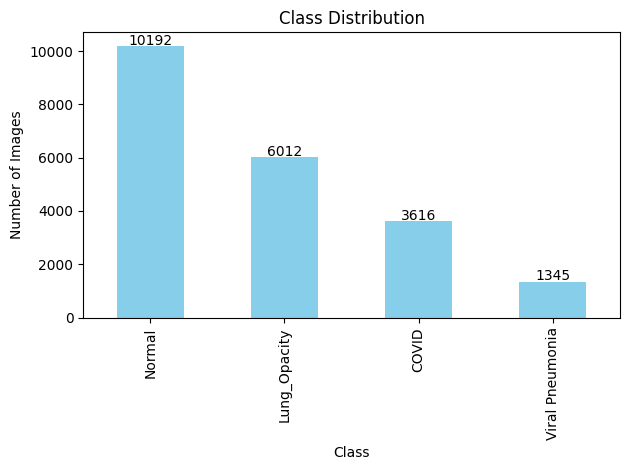

In [5]:
#number of images per class (COVID, Normal, etc.)to reveal class imbalance, which affects model training fairness.
#Plot class distribution
class_counts = df_all['label'].value_counts()
ax = class_counts.plot(kind='bar', title='Class Distribution', color='skyblue')
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.tight_layout()

# Add value labels on top of each bar
for i, count in enumerate(class_counts):
    plt.text(i, count + 50, str(count), ha='center', fontsize=10)
plt.show()

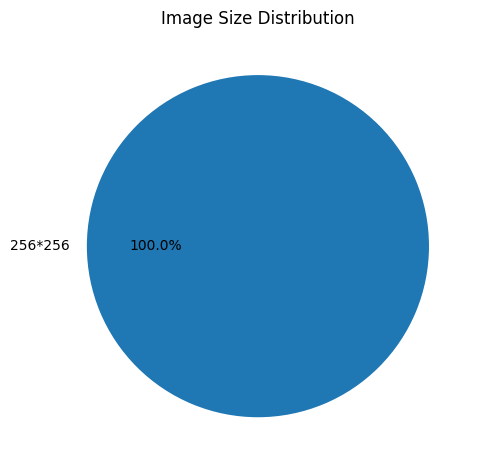

['256*256']


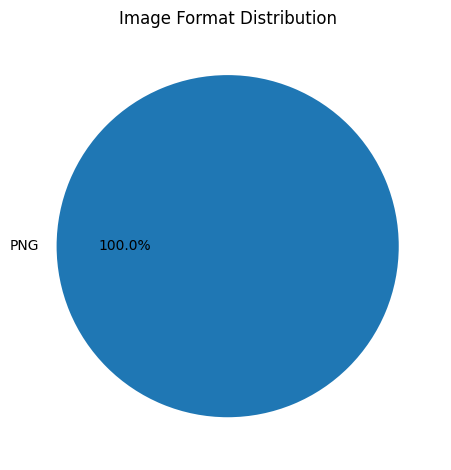

['PNG']


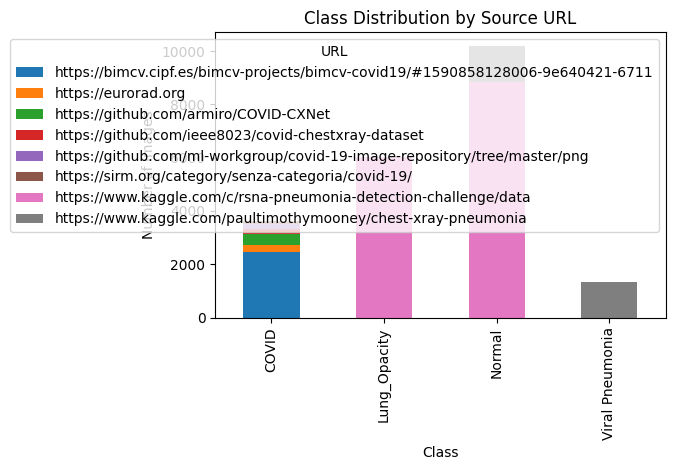

label            URL                                                                            
COVID            https://bimcv.cipf.es/bimcv-projects/bimcv-covid19/#1590858128006-9e640421-6711    2474
                 https://eurorad.org                                                                 258
                 https://github.com/armiro/COVID-CXNet                                               400
                 https://github.com/ieee8023/covid-chestxray-dataset                                 182
                 https://github.com/ml-workgroup/covid-19-image-repository/tree/master/png           183
                 https://sirm.org/category/senza-categoria/covid-19/                                 119
Lung_Opacity     https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/data                   6012
Normal           https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/data                   8851
                 https://www.kaggle.com/paultimothymooney/chest

In [ ]:
#Image Size Consistency Pie Chart to confirm dataset consistency
df_all['SIZE'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Image Size Distribution')
plt.ylabel('')
plt.tight_layout()
plt.show()
print(df_all['SIZE'].unique())

#File Format Distribution Pie Chart to Ensure compatibility during processing
df_all['FORMAT'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Image Format Distribution')
plt.ylabel('')
plt.tight_layout()
plt.show()
print(df_all['FORMAT'].unique())

#Class Proportion by Dataset Source URL to Identify potential dataset bias by source
df_all.groupby(['label', 'URL']).size().unstack().plot(kind='bar', stacked=True)
plt.title('Class Distribution by Source URL')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.tight_layout()
plt.show()
print(df_all.groupby(['label', 'URL']).size())

In [8]:
#look if there are masks for all images
missing_masks = []

for idx, row in df_all.iterrows():
    label = row['label']
    file = row['FILE NAME']

    if not file.lower().endswith('.png'):
        file += '.png'

    mask_path = os.path.join(base_path, label, 'masks', file)

    if not os.path.exists(mask_path):
        missing_masks.append(mask_path)

print(f"Total images without masks: {len(missing_masks)}")

Total images without masks: 0


In [ ]:
# Define a function to analyze image pixel statistics and data quality
def analyze_image_pixels(df, base_path, n_show=5):
    """
    Function to:
    - Loop through each image in the dataset
    - Compute pixel statistics (min, max, mean, std deviation)
    - Flag likely blank images (very low contrast)
    - Return a DataFrame with summary stats for all images
    """
    results = []  # Empty list to store image stats for each image

    #  Loop through each row of the metadata DataFrame
    for idx, row in df.iterrows():
        label = row['label']  # Image class label (COVID, Normal, etc.)
        file = row['FILE NAME']  # Image filename

        # Ensure file has .png extension
        if not file.lower().endswith('.png'):
            file += '.png'

        #  Construct full image path inside 'images' folder for each label/class
        image_path = os.path.join(base_path, label, 'images', file)

        #  Check if image file exists at that path
        if os.path.exists(image_path):
            # Open image and convert it to grayscale (1 channel)
            img = Image.open(image_path).convert('L')

            # Convert image to numpy array of pixel values
            pixels = np.array(img)

            # Calculate basic pixel value statistics
            min_val = pixels.min()
            max_val = pixels.max()
            mean_val = pixels.mean()
            std_val = pixels.std()

            #  Flag images as 'blank' if pixel contrast is very low (std dev < 5)
            flag_blank = std_val < 5

            # Store image stats as a dictionary and add to results list
            results.append({
                'label': label,
                'file': file,
                'min_pixel': min_val,
                'max_pixel': max_val,
                'mean_pixel': mean_val,
                'std_pixel': std_val,
                'blank_image': flag_blank
            })
            #min_pixel: darkest pixel
            # max_pixel: brightest pixel
            # mean_pixel: average brightness
            # std_pixel: contrast (variation in brightness)
    # Convert the results list into a Pandas DataFrame
    result_df = pd.DataFrame(results)
    return result_df


# Run the analysis function on combined image metadata DataFrame
image_stats_df = analyze_image_pixels(df_all, base_path, n_show=5)
#save processed DataFrame (image_stats_df) to a file after the first run:
image_stats_df.to_csv("image_stats_summary.csv", index=False)       

In [12]:
print(image_stats_df.head())


   label         file  min_pixel  max_pixel  mean_pixel  std_pixel  \
0  COVID  COVID-1.png          0        255  145.896847  51.816632   
1  COVID  COVID-2.png         32        238  150.640530  48.867698   
2  COVID  COVID-3.png          0        255  140.598617  50.200679   
3  COVID  COVID-4.png          1        255  116.714679  57.719773   
4  COVID  COVID-5.png         34        246  167.835796  48.413412   

   blank_image  
0        False  
1        False  
2        False  
3        False  
4        False  


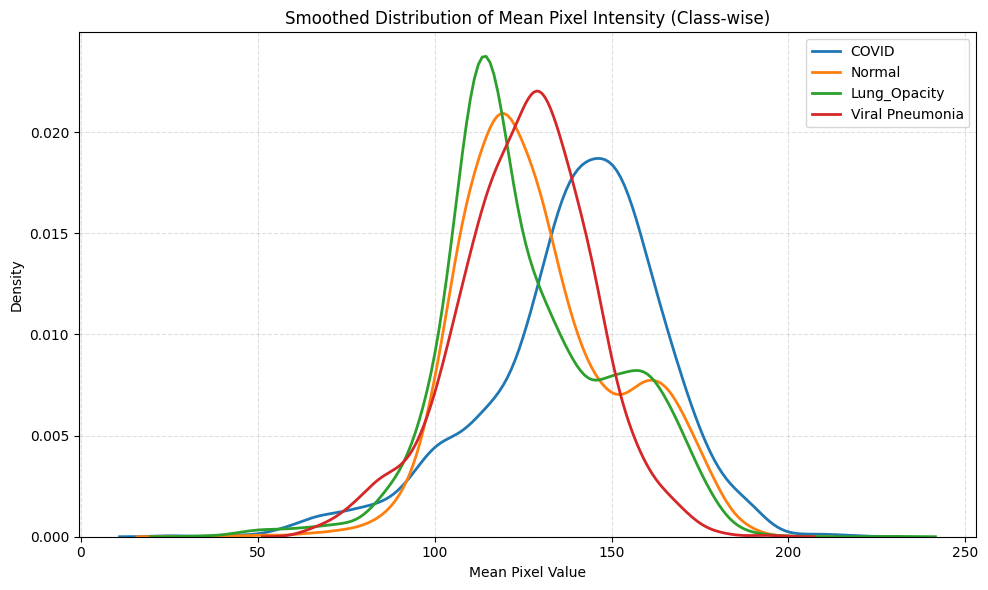

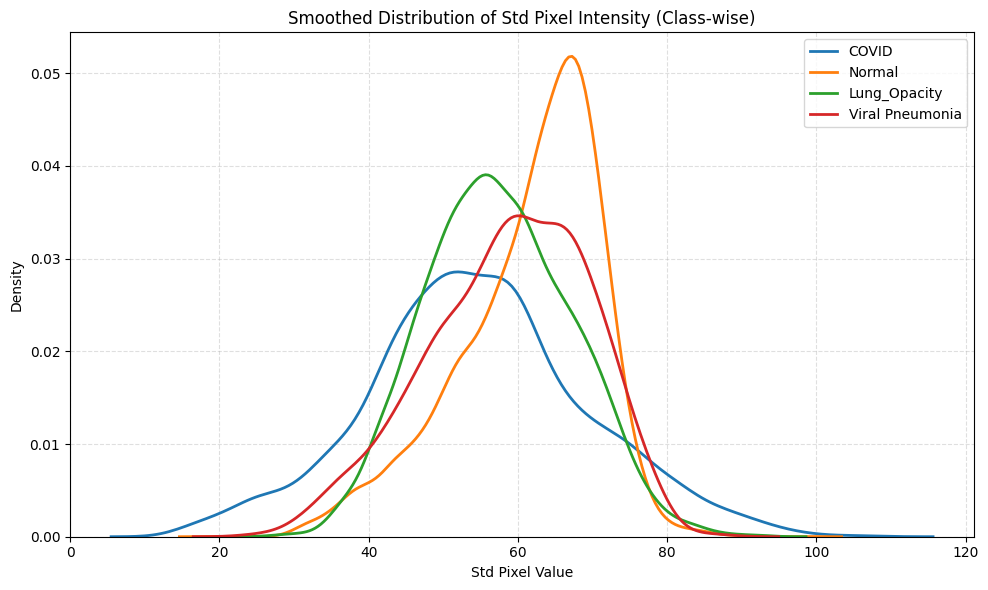

In [16]:
# Get unique class labels
classes = image_stats_df['label'].unique()
#univariate analysis
# Create KDE plot for mean pixel values by class
plt.figure(figsize=(10, 6))

for cls in classes:
    class_data = image_stats_df[image_stats_df['label'] == cls]['mean_pixel']
    sns.kdeplot(class_data, label=cls, linewidth=2)

plt.title("Smoothed Distribution of Mean Pixel Intensity (Class-wise)")
plt.xlabel("Mean Pixel Value")
plt.ylabel("Density")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()
# Create KDE plot for std pixel values by class
plt.figure(figsize=(10, 6))

for cls in classes:
    class_data = image_stats_df[image_stats_df['label'] == cls]['std_pixel']
    sns.kdeplot(class_data, label=cls, linewidth=2)

plt.title("Smoothed Distribution of Std Pixel Intensity (Class-wise)")
plt.xlabel("Std Pixel Value")
plt.ylabel("Density")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

In [17]:
# Get all unique URLs in the dataset
unique_urls = df_all['URL'].unique()
print(f"Unique URLs: {unique_urls}")


Unique URLs: ['https://sirm.org/category/senza-categoria/covid-19/'
 'https://github.com/ml-workgroup/covid-19-image-repository/tree/master/png'
 'https://eurorad.org' 'https://github.com/armiro/COVID-CXNet'
 'https://github.com/ieee8023/covid-chestxray-dataset'
 'https://bimcv.cipf.es/bimcv-projects/bimcv-covid19/#1590858128006-9e640421-6711'
 'https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/data'
 'https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia']


In [ ]:
#Loops through that DataFrame:For each image (by URL and filename), it opens the image file locally
#Converts to grayscale
#Computes mean pixel intensity
#Stores metadata like filename, format, mode, width, height, and computed mean_intensity
#Organizes this into a dictionary keyed by URL (url_metadata)
#Converts this dictionary into DataFrames for analysis
#Groups by URL
#Computes mean pixel intensities
#Works off pre-existing metadata files
#Consolidates and combines for detailed analysis

#Loop through your DataFrame to collect metadata
for idx, row in df_all.iterrows():
    label = row['label']
    url = row['URL']
    file = row['FILE NAME'] if 'FILE NAME' in row else row['filename']
    if not file.lower().endswith(('.png', '.jpg', '.jpeg')):
        file += '.png'  # fallback

    image_path = os.path.join(base_path, label, 'images', file)
    if os.path.exists(image_path):
        try:
            with Image.open(image_path) as img:
                img_gray = img.convert("L")  # ensure for histogram
                pixel_data = np.array(img_gray).flatten()

                info = {
                    "filename": file,
                    "format": img.format,
                    "mode": img.mode,
                    "width": img.size[0],
                    "height": img.size[1],
                    "mean_intensity": np.mean(pixel_data),
                    "label": label
                }
                url_metadata[url].append(info)
        except Exception as e:
            print(f"Error processing {image_path}: {e}")
    else:
        print(f"Missing file: {image_path}")

# Convert to DataFrame for analysis
metadata_dfs = []
for url, items in url_metadata.items():
    df = pd.DataFrame(items)
    df['URL'] = url
    metadata_dfs.append(df)

df_analysis = pd.concat(metadata_dfs, ignore_index=True)



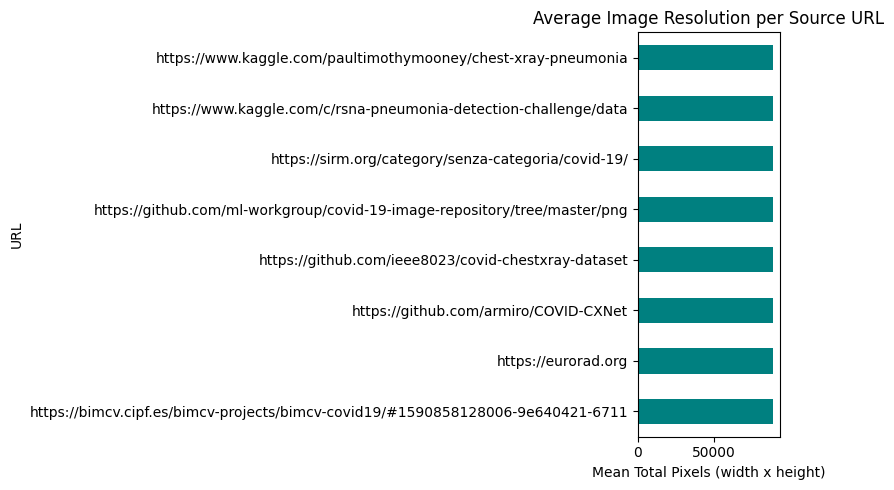

In [ ]:
#plot Average Image Resolution per Source URL
df_analysis['resolution'] = df_analysis['width'] * df_analysis['height']
avg_res = df_analysis.groupby('URL')['resolution'].mean().sort_values()
avg_res.plot(kind='barh', figsize=(8, 5), color='teal')
plt.title("Average Image Resolution per Source URL")
plt.xlabel("Mean Total Pixels (width x height)")
plt.tight_layout()
plt.show()


C:\Users\arfin\AppData\Local\Temp\ipykernel_48852\3701027730.py:6: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


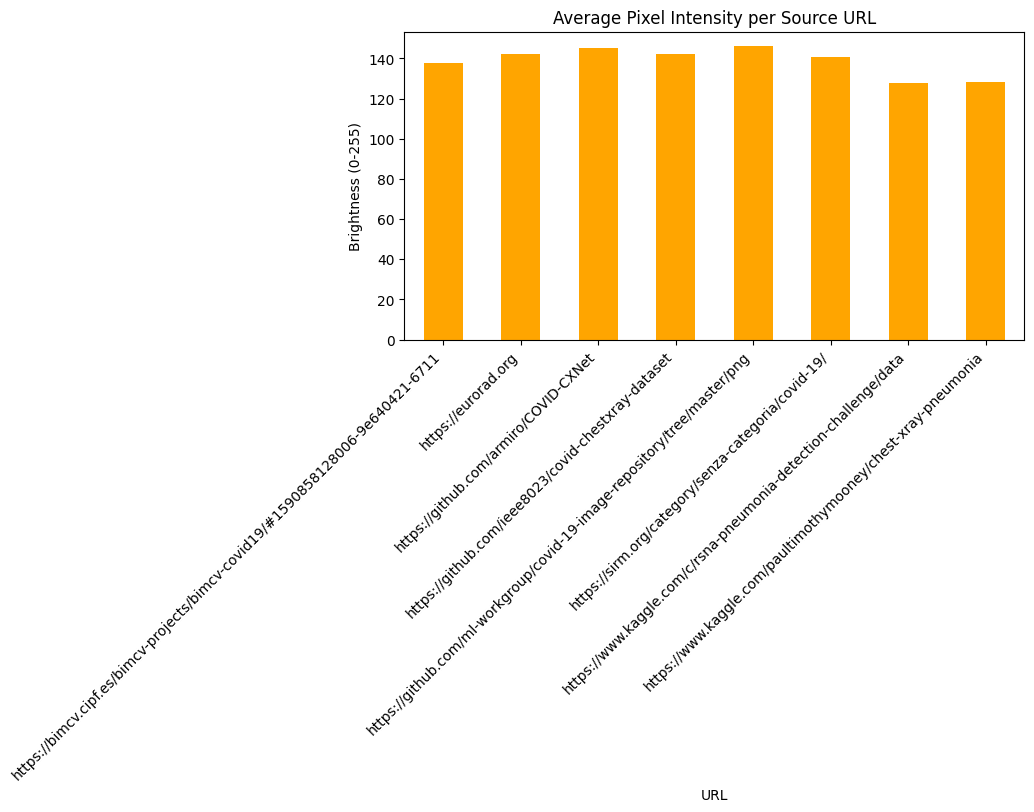

In [ ]:
#plot Average Pixel Intensity per Source URL
avg_intensity = df_analysis.groupby('URL')['mean_intensity'].mean()
avg_intensity.plot(kind='bar', figsize=(8, 4), color='orange')
plt.title("Average Pixel Intensity per Source URL")
plt.ylabel("Brightness (0-255)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


C:\Users\arfin\AppData\Local\Temp\ipykernel_48852\3941885589.py:7: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


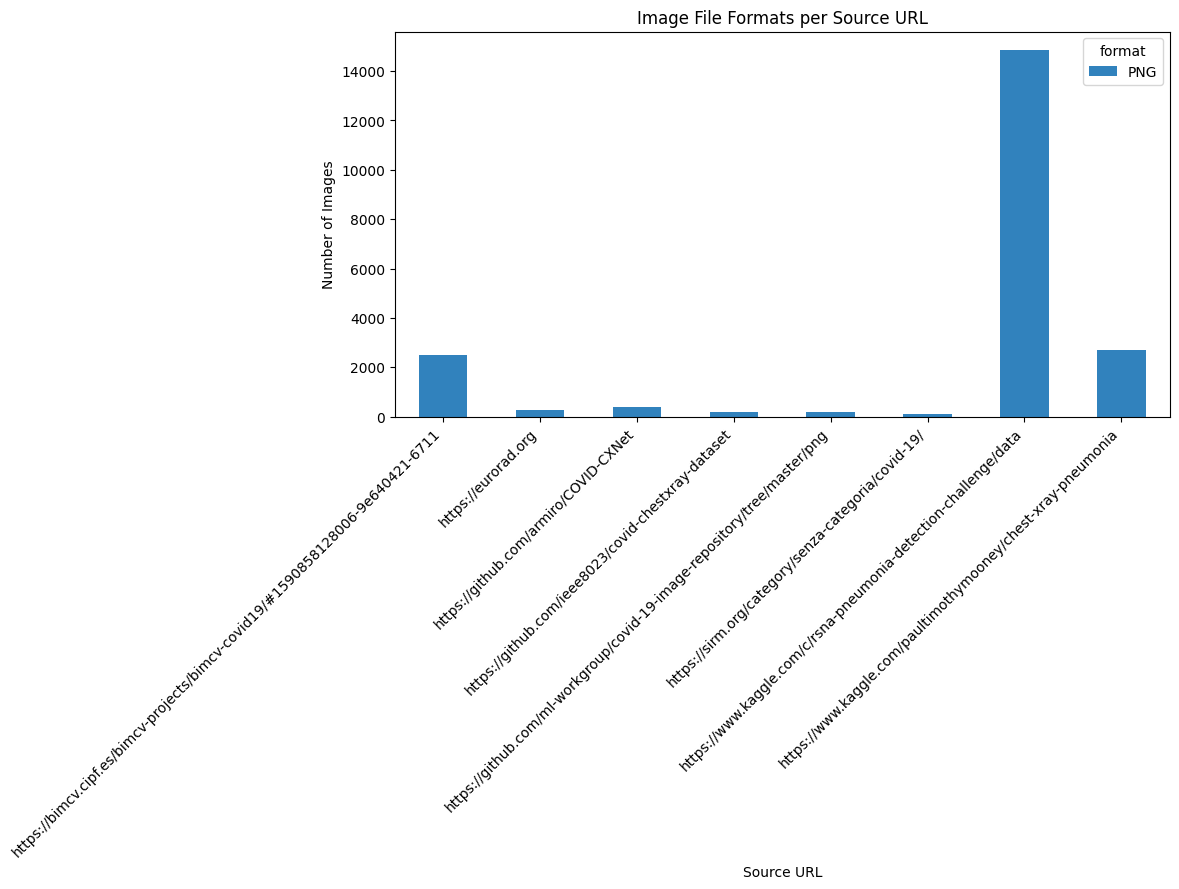

In [ ]:
#mage File Formats per Source URL
format_counts = df_analysis.groupby(['URL', 'format']).size().unstack().fillna(0)
format_counts.plot(kind='bar', stacked=True, figsize=(10, 5), colormap='tab20c')
plt.title("Image File Formats per Source URL")
plt.ylabel("Number of Images")
plt.xlabel("Source URL")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [36]:
# Convert the metadata list to a Pandas DataFrame
df_metadata = pd.DataFrame(metadata_list)

# Specify the output file path for the Excel file
output_path = "image_metadata_summary.xlsx"

# Save the DataFrame to an Excel file
df_metadata.to_excel(output_path, index=False)

# Print message indicating successful export
print(f"\nMetadata successfully saved to: {output_path}")



Metadata successfully saved to: image_metadata_summary.xlsx


In [ ]:
# Loop through our DataFrame to collect metadata and normalize pixel intensities
for idx, row in df_all.iterrows():
    label = row['label']
    url = row['URL']
    file = row['FILE NAME'] if 'FILE NAME' in row else row['filename']
    if not file.lower().endswith(('.png', '.jpg', '.jpeg')):
        file += '.png'  # fallback

    image_path = os.path.join(base_path, label, 'images', file)
    if os.path.exists(image_path):
        try:
            with Image.open(image_path) as img:
                img_gray = img.convert("L")  # Convert to grayscale
                pixel_data = np.array(img_gray).flatten()

                # Normalize pixel intensity to [0, 1]
                min_val = np.min(pixel_data)
                max_val = np.max(pixel_data)

                if max_val != min_val:
                   pixel_data_normalized = (pixel_data - min_val) / (max_val - min_val)
                   mean_intensity_normalized = np.mean(pixel_data_normalized)
                else:
                   pixel_data_normalized = np.zeros_like(pixel_data, dtype=float)
                   mean_intensity_normalized = 0.0  # or set it to 1.0 if you prefer

                # Calculate the mean intensity of the normalized pixels
                mean_intensity_normalized = np.mean(pixel_data_normalized)

                info = {
                    "filename": file,
                    "format": img.format,
                    "mode": img.mode,
                    "width": img.size[0],
                    "height": img.size[1],
                    "mean_intensity_normalized": mean_intensity_normalized,
                    "label": label
                }
                url_metadata[url].append(info)
        except Exception as e:
            print(f"Error processing {image_path}: {e}")
    else:
        print(f"Missing file: {image_path}")

# Convert to DataFrame for analysis
metadata_dfs = []
for url, items in url_metadata.items():
    df = pd.DataFrame(items)
    df['URL'] = url
    metadata_dfs.append(df)

df_analysis = pd.concat(metadata_dfs, ignore_index=True)

# Display the first few rows of the DataFrame with normalized pixel intensities
print(df_analysis[['URL', 'filename', 'mean_intensity_normalized']].head(10))



                                                 URL     filename  \
0                                             group1          NaN   
1                                             group1          NaN   
2                                             group2          NaN   
3                                             group2          NaN   
4  https://sirm.org/category/senza-categoria/covi...  COVID-1.png   
5  https://sirm.org/category/senza-categoria/covi...  COVID-2.png   
6  https://sirm.org/category/senza-categoria/covi...  COVID-3.png   
7  https://sirm.org/category/senza-categoria/covi...  COVID-4.png   
8  https://sirm.org/category/senza-categoria/covi...  COVID-5.png   
9  https://sirm.org/category/senza-categoria/covi...  COVID-6.png   

   mean_intensity_normalized  
0                        NaN  
1                        NaN  
2                        NaN  
3                        NaN  
4                   0.572144  
5                   0.575925  
6                   0.5

,width,height,mean_intensity_normalized
count,84660.0,84660.0,84660.000000
mean,299.0,299.0,0.532349
std,0.0,0.0,0.094166
min,299.0,299.0,0.100045
25%,299.0,299.0,0.466847
50%,299.0,299.0,0.523884
75%,299.0,299.0,0.600207
max,299.0,299.0,0.896567


In [55]:
print(df_analysis[df_analysis['mean_intensity_normalized'].isna()])
# Remove rows where 'mean_intensity_normalized' is NaN
df_analysis = df_analysis.dropna(subset=['mean_intensity_normalized'])

# Check the result
print(df_analysis)


                                            0     URL filename format mode  \
0       https://example.com/path/to/README.md  group1      NaN    NaN  NaN   
1   https://example.com/path/to/metadata.json  group1      NaN    NaN  NaN   
2      https://example.com/path/to/README2.md  group2      NaN    NaN  NaN   
3  https://example.com/path/to/metadata2.json  group2      NaN    NaN  NaN   

   width  height  mean_intensity_normalized label  
0    NaN     NaN                        NaN   NaN  
1    NaN     NaN                        NaN   NaN  
2    NaN     NaN                        NaN   NaN  
3    NaN     NaN                        NaN   NaN  
         0                                                URL  \
4      NaN  https://sirm.org/category/senza-categoria/covi...   
5      NaN  https://sirm.org/category/senza-categoria/covi...   
6      NaN  https://sirm.org/category/senza-categoria/covi...   
7      NaN  https://sirm.org/category/senza-categoria/covi...   
8      NaN  https://sirm

In [56]:
out_of_bounds = df_analysis[
    (df_analysis['mean_intensity_normalized'] < 0) | 
    (df_analysis['mean_intensity_normalized'] > 1)
]

print("Out-of-bound values:\n", out_of_bounds)


Out-of-bound values:
 Empty DataFrame
Columns: [0, URL, filename, format, mode, width, height, mean_intensity_normalized, label]
Index: []


label
Lung_Opacity       0.521697
Normal             0.524133
Viral Pneumonia    0.528387
COVID              0.574691
Name: mean_intensity_normalized, dtype: float64


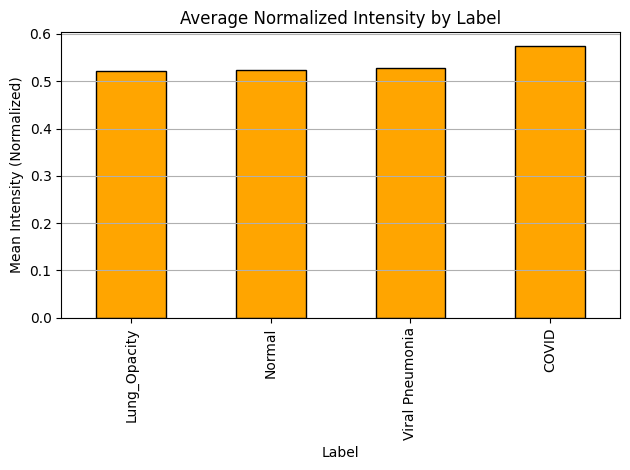

In [57]:
mean_by_label = df_analysis.groupby('label')['mean_intensity_normalized'].mean().sort_values()
print(mean_by_label)

# Optional: bar plot
mean_by_label.plot(kind='bar', color='orange', edgecolor='black')
plt.title("Average Normalized Intensity by Label")
plt.ylabel("Mean Intensity (Normalized)")
plt.xlabel("Label")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


URL
https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/data                   0.522348
https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia                      0.530687
https://bimcv.cipf.es/bimcv-projects/bimcv-covid19/#1590858128006-9e640421-6711    0.569141
https://sirm.org/category/senza-categoria/covid-19/                                0.570192
https://eurorad.org                                                                0.576541
https://github.com/ml-workgroup/covid-19-image-repository/tree/master/png          0.587745
https://github.com/ieee8023/covid-chestxray-dataset                                0.589343
https://github.com/armiro/COVID-CXNet                                              0.596521
Name: mean_intensity_normalized, dtype: float64


C:\Users\arfin\AppData\Local\Temp\ipykernel_48852\110071473.py:9: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


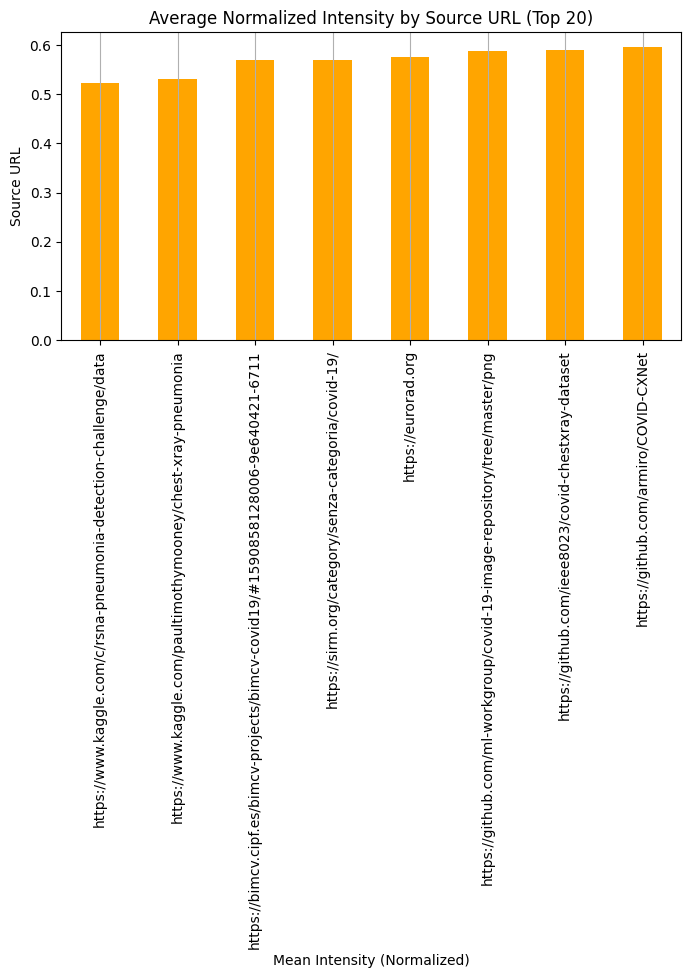

In [58]:
mean_by_url = df_analysis.groupby('URL')['mean_intensity_normalized'].mean().sort_values()
print(mean_by_url)

# Optional: plot top 20 sources (if too many)
mean_by_url.head(20).plot(kind='bar', figsize=(8, 4), color='orange')
plt.title("Average Normalized Intensity by Source URL (Top 20)")
plt.xlabel("Mean Intensity (Normalized)")
plt.ylabel("Source URL")
plt.tight_layout()
plt.grid(axis='x')
plt.show()
